In [1]:
!pip install legume-gme

     |████████████████████████████████| 61kB 4.4MB/s 


In [4]:
import numpy as np
import legume
import matplotlib.pyplot as plt

#from legume import PlaneWaveExp, Circle, ShapesLayer, Lattice, viz

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
#The idea is to create a class that automatically defines cavity geometries for you. Starting with the only changes to the cavity being shifts. 
#All of our crystals, including the shifts, have mirror symmetry about the x and y axes.

'''
attributes:
  type: A string indicating the type of crystal to be defined. Currently, implementing "L3", "L4", "H1", and "H2"
  dx: an array with length (Nx//2+1)*(Ny//2+1) of x shifts of all holes in one quadrant
  dy: an array with length (Nx//2+1)*(Ny//2+1) of y shifts of all holes in one quadrant. 
      Note that the implementation 
  rads: an array with length (Nx//2+1)*(Ny//2+1) of radii of all holes in one quadrant.
  supercell: An array containing the dimensions of the supercell. [Nx, Ny]
  thickness: the thickness of the crystal, normalized to the lattice constant.
  eps: permittivity of slab material.
'''

class photonicCrystalCavity:
  #dx and dy should be optional arguments
  def __init__(self, crystal, rads, supercell, thickness, eps, *displacements, **kwargs):
    #not sure if i have to store all these once i create the appropriate lattice...
    self.crystal = crystal
    self.supercell = supercell
    self.thick = thickness
    self.eps = eps

    Nx = supercell[0]
    Ny = supercell[1]

    #default hexagonal supercell
    lattice = legume.Lattice([Nx, 0], [0, Ny*np.sqrt(3)/2])
    self.lattice = lattice

    #generate holes. Note H0 cavity is different wrt. this.
    xp, yp = [], []
    nx, ny = Nx//2 + 1, Ny//2 + 1

    if crystal == 'H0':
      for iy in range(ny):
        for ix in range(nx):
          xp.append(ix + ((iy+1)%2)*0.5)
          yp.append(iy*np.sqrt(3)/2)
    else:
      for iy in range(ny):
        for ix in range(nx):
          xp.append(ix + (iy%2)*0.5)
          yp.append(iy*np.sqrt(3)/2)

    #remove appropriate holes. Each of these methods takes the default 
    #hexagonal lattice coordinates and supercell size, 
    #and returns coordinates with the appropriate holes removed.
    def H0(xp, yp, Nx, Ny):
      return xp, yp

    def H1(xp, yp, Nx, Ny):
      return xp[1:], yp[1:]

    def H2(xp, yp, Nx, Ny):
      newx = xp.copy()
      newy = yp.copy()

      #remove the Nx//2+2th hole
      del newx[Nx//2+1]
      del newy[Nx//2+1]

      return newx[2:], newy[2:]

    def L3(xp, yp, Nx, Ny):
      return xp[2:], yp[2:]
    
    def L5(xp, yp, Nx, Ny):
      return xp[3:], yp[3:]

    def removeholes(crystal, xp, yp, Nx, Ny):
      switcher = {
        'H0': H0,
        'H1': H1,
        'H2': H2,
        'L3': L3,
        'L5': L5
      }
      # Get the function from switcher dictionary. need a better way to deal with invalid crystal types
      holesBeGone = switcher.get(crystal, lambda: "Invalid crystal; it might not be implemented yet.")
      # Execute the function
      return holesBeGone(xp, yp, Nx, Ny)

    xp, yp = removeholes(crystal, xp, yp, Nx, Ny)
    self.xp, self.yp = xp, yp
    cryst = legume.PhotCryst(lattice)
    cryst.add_layer(d=self.thick, eps_b=eps)
    #displacements (default 0)
    if len(displacements) == 0:
      self.dx = np.zeros(len(xp))
      self.dy = np.zeros(len(yp))
    else: #maybe include a check here to make sure displacements is the right size?
      self.dx = displacements[0]
      self.dy = displacements[1]
    if len(rads) == len(xp):
      self.rads = rads
    else:
      self.rads = rads[0]*np.ones(len(xp))
      
    for ic, x in enumerate(xp):
      yc = yp[ic] if yp[ic] == 0 else yp[ic] + self.dy[ic]
      xc = x if x == 0 else xp[ic] + self.dx[ic]
      cryst.add_shape(legume.Circle(x_cent=xc, y_cent=yc, r=self.rads[ic]))
      
      if nx-0.6 > xp[ic] > 0 and (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0:
          cryst.add_shape(legume.Circle(x_cent=-xc, y_cent=-yc, r=self.rads[ic]))
      if nx-1.6 > xp[ic] > 0:
          cryst.add_shape(legume.Circle(x_cent=-xc, y_cent=yc, r=self.rads[ic]))
      if (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0 and nx-1.1 > xp[ic]:
          cryst.add_shape(legume.Circle(x_cent=xc, y_cent=-yc, r=self.rads[ic]))

    #et voila! the crystal should be defined.
    self.phc = cryst

  def getcryst(self):
    return self.phc.copy()

  def getsupercell(self):
    return self.supercell.copy()
  
  def getbase(self):
    '''
    lattice = legume.Lattice([self.supercell[0], 0], [0, self.supercell[1]*np.sqrt(3)/2])

    xp, yp = [], []
    nx, ny = self.supercell[0]//2+1, self.supercell[1]//2+1
    if self.crystal == 'H0':
      for iy in range(ny):
        for ix in range(nx):
          xp.append(ix + ((iy+1)%2)*0.5)
          yp.append(iy*np.sqrt(3)/2)
    else:
      for iy in range(ny):
        for ix in range(nx):
          xp.append(ix + (iy%2)*0.5)
          yp.append(iy*np.sqrt(3)/2)
    '''
    
    cryst = legume.PhotCryst(self.lattice)
    cryst.add_layer(d=self.thick, eps_b=self.eps)
    #since the area of the holes matters, I want the radii of the base crystal
    #holes to be such that the total area of the holes is the same.
    averagerad = np.sqrt(np.square(self.rads)/len(self.rads))

    for ic, x in enumerate(self.xp):
      yc = self.yp[ic] 
      xc = x
      cryst.add_shape(legume.Circle(x_cent=xc, y_cent=yc, r=averagerad))
      
      if nx-0.6 > xp[ic] > 0 and (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0:
          cryst.add_shape(legume.Circle(x_cent=-xc, y_cent=-yc, r=averagerad))
      if nx-1.6 > xp[ic] > 0:
          cryst.add_shape(legume.Circle(x_cent=-xc, y_cent=yc, r=averagerad))
      if (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0 and nx-1.1 > xp[ic]:
          cryst.add_shape(legume.Circle(x_cent=xc, y_cent=-yc, r=averagerad))

    return cryst
  

  #im thinking about whether or not there's a better way of doing this... 
  #i suppose for this and the above method i could store the default lattice instead of having to make it every time
  def modify(self, dx, dy, rad):
    #lattice = legume.Lattice([self.supercell[0], 0], [0, self.supercell[1]*np.sqrt(3)/2])
    cryst = legume.PhotCryst(self.lattice)
    cryst.add_layer(d=self.thick, eps_b=self.eps)
    for ic, x in enumerate(self.xp):
      yc = self.yp[ic] if self.yp[ic] == 0 else self.yp[ic] + dy[ic]
      xc = x if x == 0 else self.xp[ic] + dx[ic]
      cryst.add_shape(legume.Circle(x_cent=xc, y_cent=yc, r=rad[ic]))
      
      if nx-0.6 > self.xp[ic] > 0 and (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0:
          cryst.add_shape(legume.Circle(x_cent=-xc, y_cent=-yc, r=rad[ic]))
      if nx-1.6 > self.xp[ic] > 0:
          cryst.add_shape(legume.Circle(x_cent=-xc, y_cent=yc, r=rad[ic]))
      if (ny-1.1)*np.sqrt(3)/2 > self.yp[ic] > 0 and nx-1.1 > self.xp[ic]:
          cryst.add_shape(legume.Circle(x_cent=xc, y_cent=-yc, r=rad[ic]))
    
    self.phc = cryst
    self.rads = rad
    self.dx = dx
    self.dy = dy
  
  def visualize(self):
    legume.viz.eps_xy(self.phc, cbar=True)

  #maybe?
  def calcq(self):
    return
    '''
    to construct:
     - a method that modifies the stored phc based on dx, dy, rad.
     - base crystal implementation, bandgap diagram generator
     - defect margin?
     - return base crystal, super crysta, periods. done
    to do:
     - figure out how autograd works with classes in legume.
    '''



test 2:


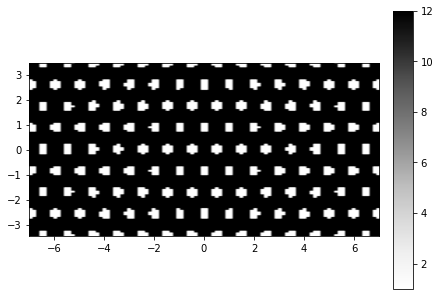

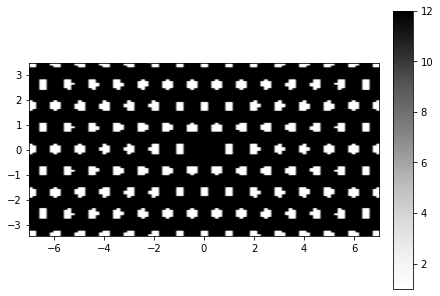

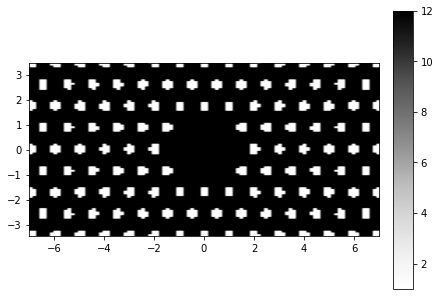

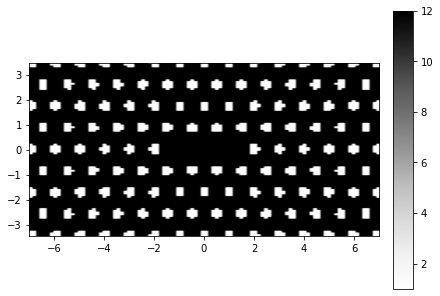

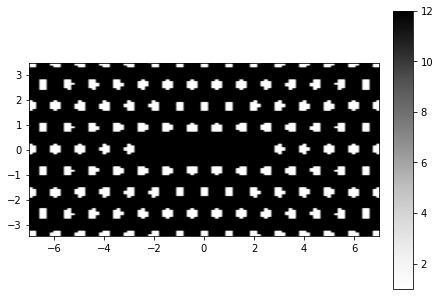

In [20]:
#testing!! first test crystal types, radii, displacements
rad1 = [0.4]
rad2 = [0.2]
supc = [14, 8]
'''
#radii
test1a = photonicCrystalCavity('H0', rad1, supc, 0.6, 12.0)
test1b = photonicCrystalCavity('H0', rad2, supc, 0.6, 12.0)

print("test 1:")
test1a.visualize()
test1b.visualize()
'''
#types
test2H0 = photonicCrystalCavity('H0', rad2, supc, 0.6, 12.0)
test2H1 = photonicCrystalCavity('H1', rad2, supc, 0.6, 12.0)
test2H2 = photonicCrystalCavity('H2', rad2, supc, 0.6, 12.0)
test2L3 = photonicCrystalCavity('L3', rad2, supc, 0.6, 12.0)
test2L5 = photonicCrystalCavity('L5', rad2, supc, 0.6, 12.0)

print("test 2:")
test2H0.visualize()
test2H1.visualize()
test2H2.visualize()
test2L3.visualize()
test2L5.visualize()


In [ ]:
#wrap this in main class?

def gme_cavity(dx, dy, xp, yp, eps, thick, rad, lattice, gmax, options):
    # Initialize PhC
    phc = cavity(dx, dy, xp, yp, eps, thick, rad, lattice)

    # For speed, we don't want to compute the loss rates of *all* modes that we store
    options['compute_im'] = False

    # Initialize GME
    gme = legume.GuidedModeExp(phc, gmax=gmax)

    # Solve for the real part of the frequencies
    gme.run(kpoints=np.array([[0], [0]]), **options)

    # Find the imaginary frequency of the fundamental cavity mode
    (freq_im, _, _) = gme.compute_rad(0, [Nx*Ny])

    # Finally, compute the quality factor
    Q = gme.freqs[0, Nx*Ny]/2/freq_im[0]
    return (gme, Q)

 
